In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


In [2]:
import timesfm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.


/Users/magnus/miniforge3/envs/timesFM/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM.


In [3]:
path = "data"

sample_submission = pd.read_csv(f"{path}/sample_submission.csv")
train = pd.read_csv(f"{path}/train.csv")
test = pd.read_csv(f"{path}/test.csv")
solution = pd.read_csv(f"{path}/solution.csv")
submission = sample_submission.copy()

# delete all values
submission.iloc[:,1:] = 0
submission

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away
0,Schoenbornstrasse_2024-09-16_0,0.0,0.0,0.0
1,Schoenbornstrasse_2024-09-16_1,0.0,0.0,0.0
2,Schoenbornstrasse_2024-09-16_2,0.0,0.0,0.0
3,Schoenbornstrasse_2024-09-16_3,0.0,0.0,0.0
4,Schoenbornstrasse_2024-09-16_4,0.0,0.0,0.0
...,...,...,...,...
1003,Kaiserstrasse_2024-09-29_19,0.0,0.0,0.0
1004,Kaiserstrasse_2024-09-29_20,0.0,0.0,0.0
1005,Kaiserstrasse_2024-09-29_21,0.0,0.0,0.0
1006,Kaiserstrasse_2024-09-29_22,0.0,0.0,0.0


In [4]:
print(len(sample_submission))
print(24*7*2*3)
sample_submission.head()

1008
1008


,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away
0,Schoenbornstrasse_2024-09-16_0,85.032614,40.935775,44.096839
1,Schoenbornstrasse_2024-09-16_1,46.097341,23.102860,22.994481
2,Schoenbornstrasse_2024-09-16_2,28.000502,14.102860,13.897642
3,Schoenbornstrasse_2024-09-16_3,21.362770,10.902659,10.460110
4,Schoenbornstrasse_2024-09-16_4,19.870045,8.812845,11.057200


In [5]:
test.head()

,id,streetname,city,date,hour,weekday,temperature,weather_condition,incidents,collection_type
0,Schoenbornstrasse_2024-09-16_0,Schoenbornstrasse,Wuerzburg,2024-09-16,0,Monday,12,cloudy,no_incident,measured
1,Schoenbornstrasse_2024-09-16_1,Schoenbornstrasse,Wuerzburg,2024-09-16,1,Monday,12,cloudy,no_incident,measured
2,Schoenbornstrasse_2024-09-16_2,Schoenbornstrasse,Wuerzburg,2024-09-16,2,Monday,10,rain,no_incident,measured
3,Schoenbornstrasse_2024-09-16_3,Schoenbornstrasse,Wuerzburg,2024-09-16,3,Monday,10,rain,no_incident,measured
4,Schoenbornstrasse_2024-09-16_4,Schoenbornstrasse,Wuerzburg,2024-09-16,4,Monday,10,rain,no_incident,measured


In [6]:
train.head()

,id,streetname,city,date,hour,weekday,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,temperature,weather_condition,incidents,collection_type
0,Schoenbornstrasse_2019-04-02_18,Schoenbornstrasse,Wuerzburg,2019-04-02,18,Tuesday,1324,682,642,18,partly-cloudy-day,no_incident,measured
1,Schoenbornstrasse_2019-04-02_19,Schoenbornstrasse,Wuerzburg,2019-04-02,19,Tuesday,1406,708,698,16,partly-cloudy-day,no_incident,measured
2,Schoenbornstrasse_2019-04-02_20,Schoenbornstrasse,Wuerzburg,2019-04-02,20,Tuesday,676,348,328,15,partly-cloudy-night,no_incident,measured
3,Schoenbornstrasse_2019-04-02_21,Schoenbornstrasse,Wuerzburg,2019-04-02,21,Tuesday,359,205,154,16,partly-cloudy-night,no_incident,measured
4,Schoenbornstrasse_2019-04-02_22,Schoenbornstrasse,Wuerzburg,2019-04-02,22,Tuesday,225,127,98,14,partly-cloudy-night,no_incident,measured


In [7]:
streetnames = train["streetname"].unique()
variables_of_interest = ["n_pedestrians", "n_pedestrians_towards", "n_pedestrians_away"]

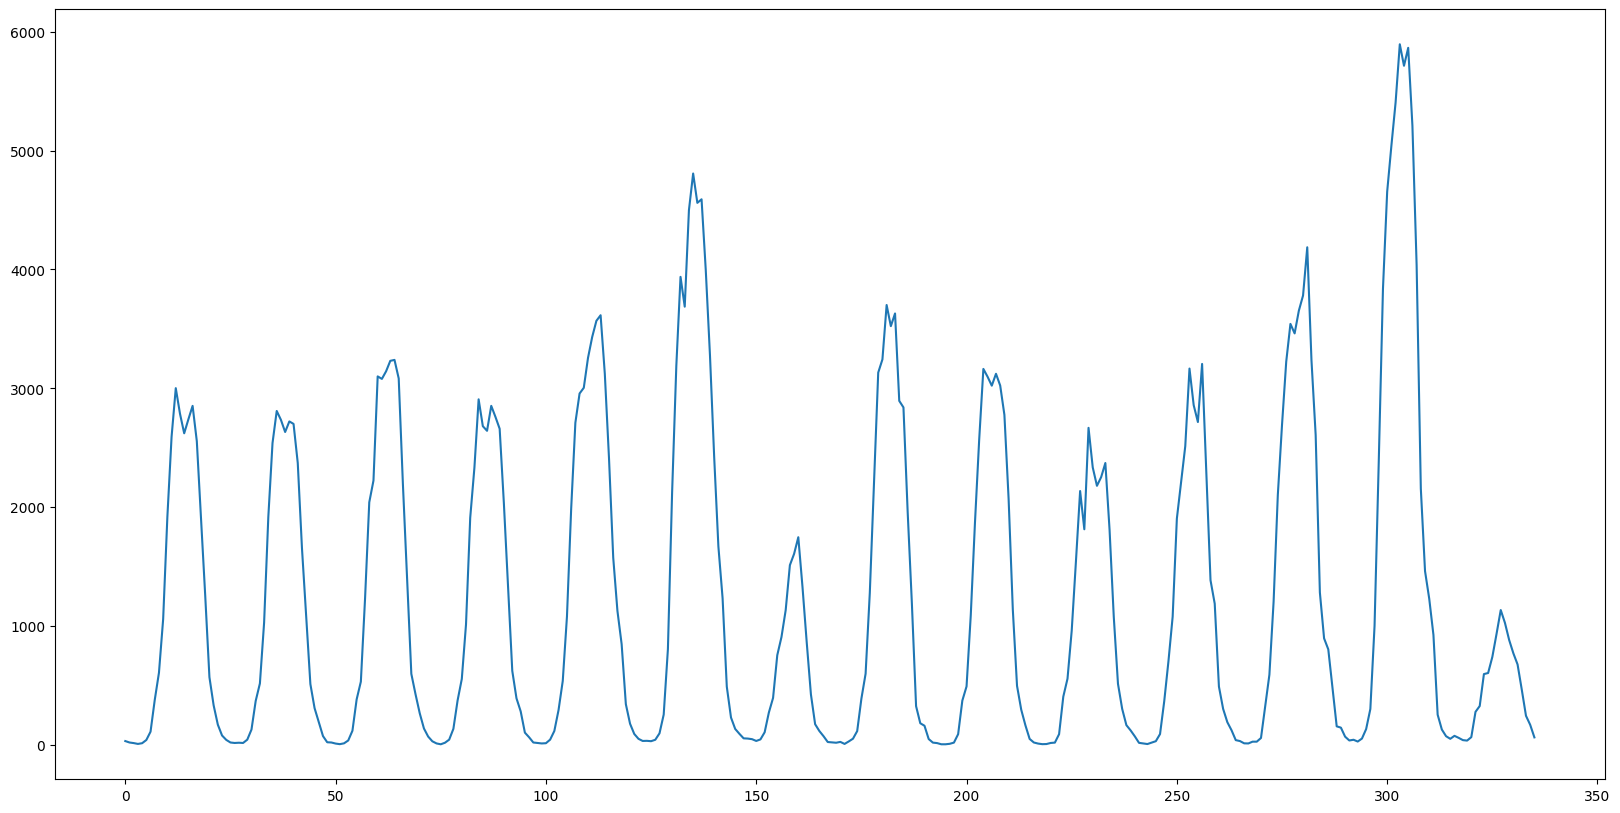

In [8]:
street = "Schoenbornstrasse"
n_last_obs = 24*14
column = "n_pedestrians"

# plot the data
plt.figure(figsize=(20,10))
plt.plot(train[train["streetname"]==street][column].values[-n_last_obs:])

/Users/magnus/miniforge3/envs/timesFM/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


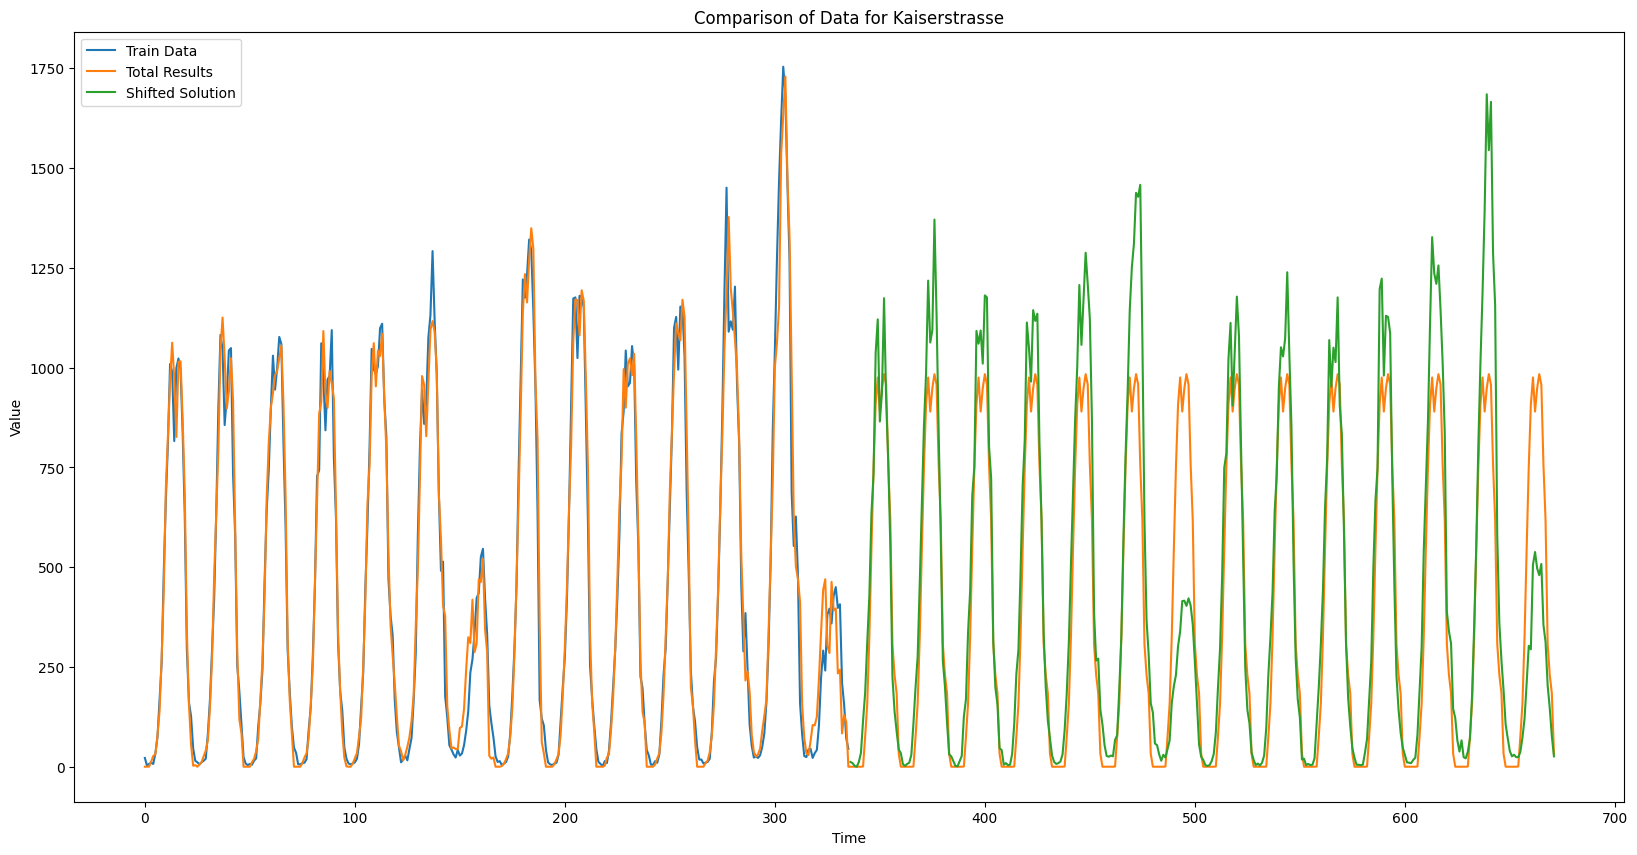

In [9]:
streetname = "Kaiserstrasse"
variable_of_interest = "n_pedestrians_away"
solution["temp_streetname"] = 0

for streetname in streetnames:
    solution["temp_streetname"] = solution.apply(
        lambda row: streetname if streetname in row['id'] else row['temp_streetname'], axis=1
    )

fitted_model = ExponentialSmoothing(train[train["streetname"]==streetname][variable_of_interest].values, seasonal="add", seasonal_periods=24).fit()

fitted_values = fitted_model.fittedvalues
train_results = fitted_values.clip(0)

val_test_results = fitted_model.forecast(24*14)
val_test_results = val_test_results.clip(0)

total_results = np.concatenate([train_results, val_test_results])

import numpy as np
import matplotlib.pyplot as plt

# Create the figure and set the size
plt.figure(figsize=(20,10))

# Plot the first dataset
plt.plot(train[train["streetname"] == streetname][variable_of_interest].values[-n_last_obs:], label='Train Data')

# Plot the second dataset
plt.plot(total_results[-n_last_obs*2:], label='Total Results')

# Ensure the "n_pedestrians" values are cast to float to handle NaN padding
n_pedestrians = solution[solution["temp_streetname"] == streetname][variable_of_interest].astype(float).values

# Shift the third dataset by n_last_obs to the right by padding with NaN values
shifted_solution = np.pad(
    n_pedestrians,
    (n_last_obs, 0), 'constant', constant_values=(np.nan,)
)

# Plot the shifted solution
plt.plot(shifted_solution, label='Shifted Solution')

# Add labels, title, and legend
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Comparison of Data for {streetname}")
plt.legend()

# Show the plot
plt.show()


In [10]:
solution

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,Usage,temp_streetname
0,Schoenbornstrasse_2024-09-16_0,19,6,13,Public,Schoenbornstrasse
1,Schoenbornstrasse_2024-09-16_1,15,8,7,Public,Schoenbornstrasse
2,Schoenbornstrasse_2024-09-16_2,7,5,2,Public,Schoenbornstrasse
3,Schoenbornstrasse_2024-09-16_3,2,0,2,Public,Schoenbornstrasse
4,Schoenbornstrasse_2024-09-16_4,6,1,5,Public,Schoenbornstrasse
...,...,...,...,...,...,...
1003,Kaiserstrasse_2024-09-29_19,595,282,313,Private,Kaiserstrasse
1004,Kaiserstrasse_2024-09-29_20,416,212,204,Private,Kaiserstrasse
1005,Kaiserstrasse_2024-09-29_21,304,157,147,Private,Kaiserstrasse
1006,Kaiserstrasse_2024-09-29_22,158,82,76,Private,Kaiserstrasse


In [11]:
submission["temp_streetname"] = 0

# where streename is part of id string add to temp_streetname
for streetname in streetnames:
    submission["temp_streetname"] = submission.apply(
        lambda row: streetname if streetname in row['id'] else row['temp_streetname'], axis=1
    )

for streetname in streetnames:
    for variable_of_interest in variables_of_interest:
        fitted_model = ExponentialSmoothing(train[train["streetname"]==streetname][variable_of_interest].values, seasonal="add", seasonal_periods=24).fit()

        fitted_values = fitted_model.fittedvalues

        val_test_results = fitted_model.forecast(24*14)

        submission.loc[submission["temp_streetname"]==streetname, variable_of_interest] = val_test_results

submission.loc[submission["n_pedestrians"] < 0, "n_pedestrians"] = submission.apply(
    lambda row: max(row["n_pedestrians_towards"], 0) + max(row["n_pedestrians_away"], 0) 
    if row["n_pedestrians"] < 0 else row["n_pedestrians"], axis=1
)

submission["n_pedestrians_towards"] = submission["n_pedestrians_towards"].clip(0)
submission["n_pedestrians_away"] = submission["n_pedestrians_away"].clip(0)


/Users/magnus/miniforge3/envs/timesFM/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/magnus/miniforge3/envs/timesFM/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/magnus/miniforge3/envs/timesFM/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/magnus/miniforge3/envs/timesFM/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/magnus/miniforge3/envs/timesFM/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/mag

In [12]:
submission

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,temp_streetname
0,Schoenbornstrasse_2024-09-16_0,24.894345,24.894345,0.000000,Schoenbornstrasse
1,Schoenbornstrasse_2024-09-16_1,55.821529,55.821529,0.000000,Schoenbornstrasse
2,Schoenbornstrasse_2024-09-16_2,76.516439,76.516439,0.000000,Schoenbornstrasse
3,Schoenbornstrasse_2024-09-16_3,20.335949,100.595749,0.000000,Schoenbornstrasse
4,Schoenbornstrasse_2024-09-16_4,88.112265,136.375500,0.000000,Schoenbornstrasse
...,...,...,...,...,...
1003,Kaiserstrasse_2024-09-29_19,1155.532874,528.839842,618.108827,Kaiserstrasse
1004,Kaiserstrasse_2024-09-29_20,560.100285,242.022137,307.407369,Kaiserstrasse
1005,Kaiserstrasse_2024-09-29_21,420.945990,184.152935,229.940650,Kaiserstrasse
1006,Kaiserstrasse_2024-09-29_22,304.202392,117.461388,183.969357,Kaiserstrasse


In [15]:
submission["temp_streetname"] = 0

# where streename is part of id string add to temp_streetname
for streetname in streetnames:
    submission["temp_streetname"] = submission.apply(
        lambda row: streetname if streetname in row['id'] else row['temp_streetname'], axis=1
    )

# for streetname in streetnames:
#     for variable_of_interest in variables_of_interest:
#         hist_mean = np.mean(train[train["streetname"]==streetname][variable_of_interest].values)

#         val_test_results = 

#         submission.loc[submission["temp_streetname"]==streetname, variable_of_interest] = val_test_results



In [17]:
square_errors_public_mean_approach 

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,Usage,temp_streetname
0,Schoenbornstrasse_2024-09-16_0,34.743307,356.996286,169.000000,Public,Schoenbornstrasse
1,Schoenbornstrasse_2024-09-16_1,1666.397190,2286.898589,49.000000,Public,Schoenbornstrasse
2,Schoenbornstrasse_2024-09-16_2,4832.535224,5114.600978,4.000000,Public,Schoenbornstrasse
3,Schoenbornstrasse_2024-09-16_3,336.207013,10119.504743,4.000000,Public,Schoenbornstrasse
4,Schoenbornstrasse_2024-09-16_4,6742.424107,18326.525942,25.000000,Public,Schoenbornstrasse
...,...,...,...,...,...,...
499,Kaiserstrasse_2024-09-22_19,310842.905271,82851.774841,68177.819661,Public,Kaiserstrasse
500,Kaiserstrasse_2024-09-22_20,4502.448284,169.576051,1884.199664,Public,Kaiserstrasse
501,Kaiserstrasse_2024-09-22_21,10804.768878,632.670122,5175.457052,Public,Kaiserstrasse
502,Kaiserstrasse_2024-09-22_22,30695.878223,1976.815053,16376.156354,Public,Kaiserstrasse


In [18]:
square_errors_public

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,Usage,temp_streetname
0,Schoenbornstrasse_2024-09-16_0,34.743307,356.996286,169.000000,Public,Schoenbornstrasse
1,Schoenbornstrasse_2024-09-16_1,1666.397190,2286.898589,49.000000,Public,Schoenbornstrasse
2,Schoenbornstrasse_2024-09-16_2,4832.535224,5114.600978,4.000000,Public,Schoenbornstrasse
3,Schoenbornstrasse_2024-09-16_3,336.207013,10119.504743,4.000000,Public,Schoenbornstrasse
4,Schoenbornstrasse_2024-09-16_4,6742.424107,18326.525942,25.000000,Public,Schoenbornstrasse
...,...,...,...,...,...,...
499,Kaiserstrasse_2024-09-22_19,310842.905271,82851.774841,68177.819661,Public,Kaiserstrasse
500,Kaiserstrasse_2024-09-22_20,4502.448284,169.576051,1884.199664,Public,Kaiserstrasse
501,Kaiserstrasse_2024-09-22_21,10804.768878,632.670122,5175.457052,Public,Kaiserstrasse
502,Kaiserstrasse_2024-09-22_22,30695.878223,1976.815053,16376.156354,Public,Kaiserstrasse


In [19]:
diffs = data_only_numpy - data_only_mean_approach_numpy

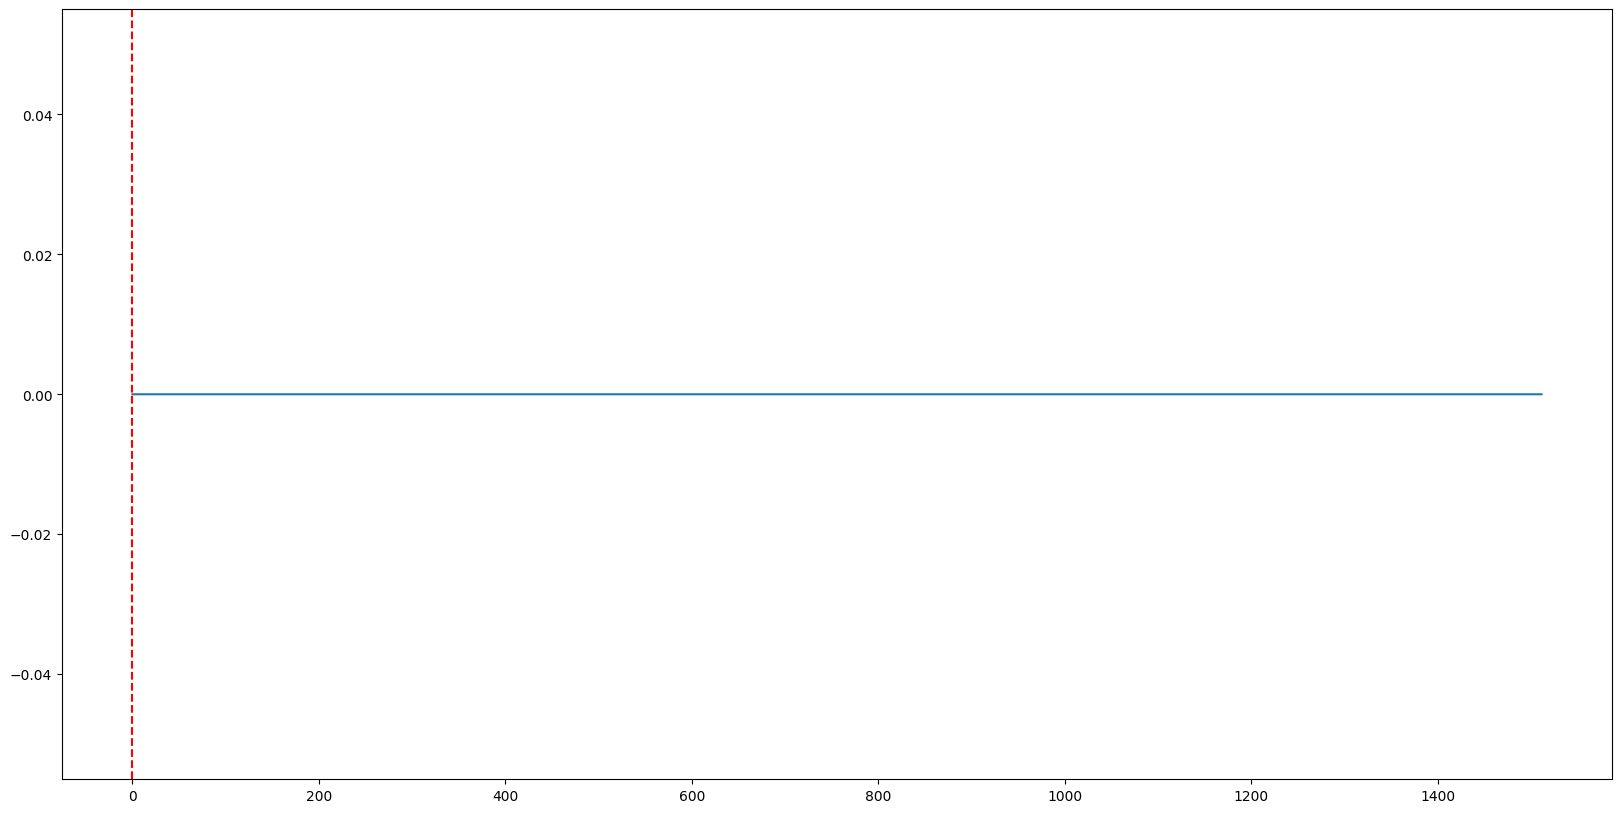

In [20]:
diffs_flat = diffs.flatten()
# sort diffs
diffs_flat= np.sort(diffs_flat)
# plot diffs

# find first index where diffs are greater than 0
first_index = np.argmax(diffs_flat > 0)

plt.figure(figsize=(20,10))
plt.plot(diffs_flat)

# add vertical line where diffs are greater than 0
plt.axvline(x=first_index, color='r', linestyle='--')



In [22]:
submission["temp_streetname"] = 0

# where streename is part of id string add to temp_streetname
for streetname in streetnames:
    submission["temp_streetname"] = submission.apply(
        lambda row: streetname if streetname in row['id'] else row['temp_streetname'], axis=1
    )

for streetname in streetnames:
    for variable_of_interest in variables_of_interest:
        
        model = LinearRegression()

        X_train = train[train["streetname"]==streetname].copy()
        X_test = test[test["streetname"]==streetname].copy()
        X_test.drop(columns=["id", "city", "streetname", "date","collection_type", "incidents", "weather_condition"], inplace=True)
        X_train.drop(columns=["id", "city", "streetname", "date", "n_pedestrians_towards", "n_pedestrians_away", "n_pedestrians", "collection_type", "incidents", "weather_condition"], inplace=True)

        y_train = train[train["streetname"]==streetname][variable_of_interest].values

        columns_one_hot = ["weekday", "hour"]
        X_train = pd.get_dummies(X_train, columns=columns_one_hot, drop_first=True)
        X_test = pd.get_dummies(X_test, columns=columns_one_hot, drop_first=True)

        # Create interaction terms between 'weekday' and 'hour'
        for weekday in [col for col in X_train.columns if col.startswith("weekday_")]:
            for hour in [col for col in X_train.columns if col.startswith("hour_")]:
                interaction_term_train = f"{weekday}_x_{hour}"
                interaction_term_test = f"{weekday}_x_{hour}"

                # Create the interaction term in both train and test sets
                X_train[interaction_term_train] = X_train[weekday] * X_train[hour]
                X_test[interaction_term_test] = X_test[weekday] * X_test[hour]

        fitted_model = model.fit(X_train, y_train)
        val_test_results = fitted_model.predict(X_test)

        # # where X_test["weekday_Saturday"] is True, multiply val_test_results by 0.5
        # val_test_results = np.where(X_test["weekday_Sunday"]==1, val_test_results*0.5, val_test_results)

        

        submission.loc[submission["temp_streetname"]==streetname, variable_of_interest] = val_test_results
submission.loc[submission["n_pedestrians"] < 0, "n_pedestrians"] = submission.apply(
    lambda row: max(row["n_pedestrians_towards"], 0) + max(row["n_pedestrians_away"], 0) 
    if row["n_pedestrians"] < 0 else row["n_pedestrians"], axis=1
)


# clip all values to be greater than 0
submission["n_pedestrians_away"] = submission["n_pedestrians_away"].clip(0)
submission["n_pedestrians_towards"] = submission["n_pedestrians_towards"].clip(0)



/var/folders/gj/ttj50jyj06d8rk20w7r1kfd00000gn/T/ipykernel_93239/962554492.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[interaction_term_train] = X_train[weekday] * X_train[hour]
/var/folders/gj/ttj50jyj06d8rk20w7r1kfd00000gn/T/ipykernel_93239/962554492.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[interaction_term_test] = X_test[weekday] * X_test[hour]
/var/folders/gj/ttj50jyj06d8rk20w7r1kfd00000gn/T/ipykernel_93239/962554492.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [315]:
submission

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,temp_streetname
0,Schoenbornstrasse_2024-09-16_0,53.742466,25.005210,28.737256,Schoenbornstrasse
1,Schoenbornstrasse_2024-09-16_1,36.654182,18.407076,18.247105,Schoenbornstrasse
2,Schoenbornstrasse_2024-09-16_2,16.332598,8.136142,8.196456,Schoenbornstrasse
3,Schoenbornstrasse_2024-09-16_3,16.667354,8.412329,8.255025,Schoenbornstrasse
4,Schoenbornstrasse_2024-09-16_4,22.619312,10.762099,11.857213,Schoenbornstrasse
...,...,...,...,...,...
1003,Kaiserstrasse_2024-09-29_19,590.270053,278.902454,311.367600,Kaiserstrasse
1004,Kaiserstrasse_2024-09-29_20,455.777009,234.836218,220.940791,Kaiserstrasse
1005,Kaiserstrasse_2024-09-29_21,318.990886,162.316681,156.674205,Kaiserstrasse
1006,Kaiserstrasse_2024-09-29_22,237.405068,130.175803,107.229264,Kaiserstrasse


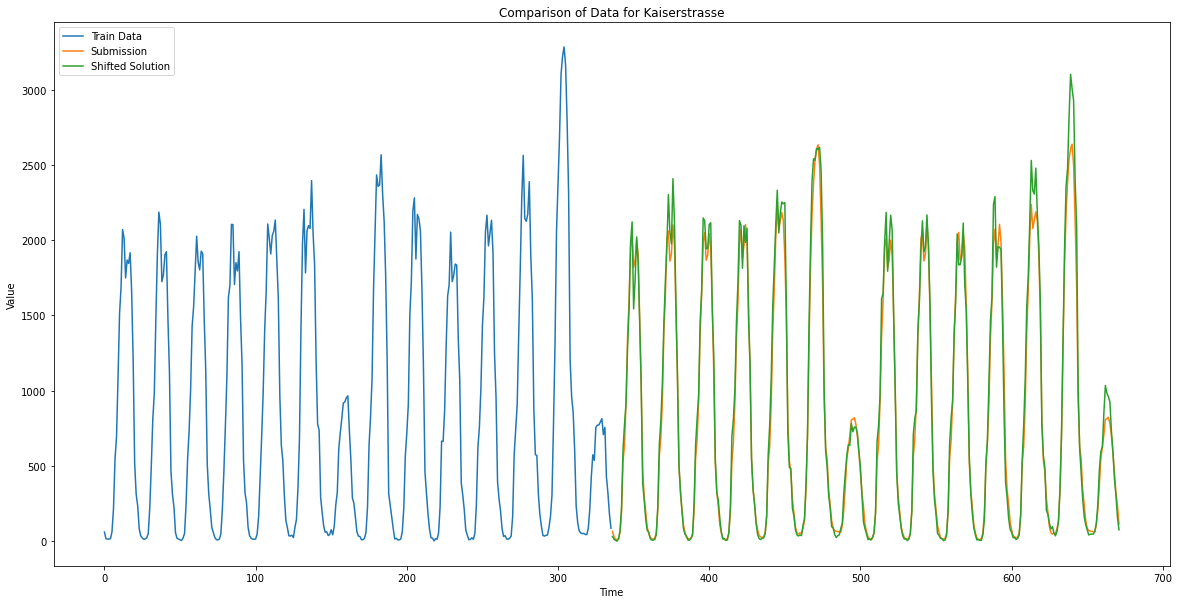

In [316]:
streetname = "Schoenbornstrasse"
variable_of_interest = "n_pedestrians"
solution["temp_streetname"] = 0

for streetname in streetnames:
    solution["temp_streetname"] = solution.apply(
        lambda row: streetname if streetname in row['id'] else row['temp_streetname'], axis=1
    )

# Create the figure and set the size
plt.figure(figsize=(20,10))

# Plot the first dataset
plt.plot(train[train["streetname"] == streetname][variable_of_interest].values[-n_last_obs:], label='Train Data')

# # Plot the second dataset
n_pedestrians = submission[submission["temp_streetname"] == streetname][variable_of_interest].values

shifted_submission = np.pad(
    n_pedestrians,
    (n_last_obs, 0), 'constant', constant_values=(np.nan,)
)

plt.plot(shifted_submission, label='Submission')

# Shift the third dataset by n_last_obs to the right by padding with NaN values
n_pedestrians = solution[solution["temp_streetname"] == streetname][variable_of_interest].astype(float).values

shifted_solution = np.pad(
    n_pedestrians,
    (n_last_obs, 0), 'constant', constant_values=(np.nan,)
)

# Plot the shifted solution
plt.plot(shifted_solution, label='Shifted Solution')

# Add labels, title, and legend
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Comparison of Data for {streetname}")
plt.legend()

# Show the plot
plt.show()


In [183]:
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="cpu",
          per_core_batch_size=256,
          horizon_len=14*28,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
  )

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 81707.22it/s]


In [184]:
train_for_timesfm = train.copy()
train_for_timesfm = train_for_timesfm[["id", "streetname", "date", "hour", "n_pedestrians", "n_pedestrians_towards", "n_pedestrians_away"]]

train_melted = train_for_timesfm.melt(
    id_vars=["id", "streetname", "date", "hour"],
    value_vars=["n_pedestrians", "n_pedestrians_towards", "n_pedestrians_away"],
    var_name="TS",
    value_name="y"
)

train_for_timesfm = train_melted

train_for_timesfm["unique_id"] = train_for_timesfm["streetname"] + "_" + train_for_timesfm["TS"]
train_for_timesfm.drop(columns=["streetname", "TS", "id"], inplace=True)

# merge date and hour
train_for_timesfm["date"] = pd.to_datetime(train_for_timesfm["date"])
train_for_timesfm["date"] = train_for_timesfm["date"].dt.strftime('%Y-%m-%d')
train_for_timesfm["date"] = train_for_timesfm["date"] + " " + train_for_timesfm["hour"].astype(str) + ":00:00"
train_for_timesfm.drop(columns=["hour"], inplace=True)

# convert to datetime
train_for_timesfm["date"] = pd.to_datetime(train_for_timesfm["date"])
# rename date to ds
train_for_timesfm.rename(columns={"date": "ds"}, inplace=True)

train_for_timesfm

,ds,y,unique_id
0,2019-04-02 18:00:00,1324,Schoenbornstrasse_n_pedestrians
1,2019-04-02 19:00:00,1406,Schoenbornstrasse_n_pedestrians
2,2019-04-02 20:00:00,676,Schoenbornstrasse_n_pedestrians
3,2019-04-02 21:00:00,359,Schoenbornstrasse_n_pedestrians
4,2019-04-02 22:00:00,225,Schoenbornstrasse_n_pedestrians
...,...,...,...
248485,2024-09-15 19:00:00,407,Kaiserstrasse_n_pedestrians_away
248486,2024-09-15 20:00:00,210,Kaiserstrasse_n_pedestrians_away
248487,2024-09-15 21:00:00,155,Kaiserstrasse_n_pedestrians_away
248488,2024-09-15 22:00:00,71,Kaiserstrasse_n_pedestrians_away


In [185]:
forecast_df = tfm.forecast_on_df(
    inputs=train_for_timesfm,
    freq="h",  # monthly
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.
TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.
Loaded 

In [186]:
forecast_df[forecast_df["ds"]=="2024-09-29 19:00:00"]
# forecast_df

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
331,Kaiserstrasse_n_pedestrians,2024-09-29 19:00:00,552.124084,354.131653,429.293884,478.410522,510.523254,552.124084,584.899658,637.391235,684.096985,772.959106
723,Kaiserstrasse_n_pedestrians_away,2024-09-29 19:00:00,311.770874,214.044647,250.853119,274.922729,291.951447,311.770874,330.105682,355.934937,379.339417,424.043457
1115,Kaiserstrasse_n_pedestrians_towards,2024-09-29 19:00:00,268.194672,159.489868,201.258148,228.621887,244.733276,268.194672,283.614502,311.831573,337.327759,383.571686
1507,Schoenbornstrasse_n_pedestrians,2024-09-29 19:00:00,716.381165,287.645020,448.076721,550.324280,614.368958,716.381165,773.481079,908.553467,995.821533,1200.109131
1899,Schoenbornstrasse_n_pedestrians_away,2024-09-29 19:00:00,330.644043,160.451172,227.622467,268.483124,295.985107,330.644043,354.190460,408.091949,444.501556,519.111267
2291,Schoenbornstrasse_n_pedestrians_towards,2024-09-29 19:00:00,329.669281,107.074097,191.459778,242.837128,273.679810,329.669281,357.358307,427.655975,476.908813,589.264160
2683,Spiegelstrasse_n_pedestrians,2024-09-29 19:00:00,521.362183,335.072693,401.534760,450.211914,477.718750,521.362183,550.270813,603.299500,649.267822,747.600769
3075,Spiegelstrasse_n_pedestrians_away,2024-09-29 19:00:00,257.504395,196.885147,218.307098,234.867966,244.971649,257.504395,268.261566,285.312805,301.010742,334.248016
3467,Spiegelstrasse_n_pedestrians_towards,2024-09-29 19:00:00,237.885559,147.995514,181.336731,203.713791,217.703949,237.885559,251.290146,277.416229,295.866394,337.018341


In [204]:
# split unique_id at first _
# Splitting unique_id at the first two occurrences of '_'

submission_timesFM = forecast_df.copy()
submission_timesFM[["streetname", "TS"]] = submission_timesFM["unique_id"].str.split("_", n=1, expand=True)

submission_timesFM.drop(columns=["unique_id"], inplace=True)

# separate date and hour
submission_timesFM["date"] = submission_timesFM["ds"].dt.strftime('%Y-%m-%d')
submission_timesFM["hour"] = submission_timesFM["ds"].dt.hour

# create id as streetname_date_hour
submission_timesFM["id"] = submission_timesFM["streetname"] + "_" + submission_timesFM["date"] + "_" + submission_timesFM["hour"].astype(str)
submission_timesFM.drop(columns=["ds"], inplace=True)
submission_timesFM.drop(columns=["date"], inplace=True)
submission_timesFM.drop(columns=["hour"], inplace=True)
# submission_timesFM.drop(columns=["TS"], inplace=True)

submission_timesFM = submission_timesFM[["timesfm", "id", "TS", "streetname"]]

submission_timesFM = submission_timesFM.pivot(index=["id", "streetname"], columns="TS", values="timesfm").reset_index()

# switch columns away and towards
submission_timesFM = submission_timesFM[["id", "n_pedestrians", "n_pedestrians_towards", "n_pedestrians_away", "streetname"]]



submission_timesFM_raw = submission_timesFM.copy()

# order rows same as sample_submission
id_sample = sample_submission["id"]
id_sample

# create empty dataframe with id_sample and columns n_pedestrians, n_pedestrians_towards, n_pedestrians_away
submission_timesFM = pd.DataFrame(id_sample, columns=["id"])

# merge submission_timesFM with submission_timesFM_raw
submission_timesFM = submission_timesFM.merge(submission_timesFM_raw, on="id", how="left")

# submission_timesFM.loc[submission_timesFM["streetname"]==streetname, variable_of_interest] = val_test_results
# submission_timesFM.loc[submission_timesFM["n_pedestrians"] < 0, "n_pedestrians"] = submission_timesFM.apply(
#     lambda row: max(row["n_pedestrians_towards"], 0) + max(row["n_pedestrians_away"], 0) 
#     if row["n_pedestrians"] < 0 else row["n_pedestrians"], axis=1
# )

# clip all values to be greater than 0
submission_timesFM["n_pedestrians_away"] = submission_timesFM["n_pedestrians_away"].clip(0)
submission_timesFM["n_pedestrians_towards"] = submission_timesFM["n_pedestrians_towards"].clip(0)
submission_timesFM["n_pedestrians"] = submission_timesFM["n_pedestrians_away"] + submission_timesFM["n_pedestrians_towards"]

# rename streetname to temp_streetname
submission_timesFM["temp_streetname"] = submission_timesFM["streetname"]
submission_timesFM.drop(columns=["streetname"], inplace=True)

submission_timesFM[submission_timesFM["id"]=="Kaiserstrasse_2024-09-29_19"]



# submission_timesFM[submission_timesFM["id"]=="Kaiserstrasse_2024-09-29_19"]

# submission_timesFM

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,temp_streetname
1003,Kaiserstrasse_2024-09-29_19,579.965576,268.194672,311.770874,Kaiserstrasse


In [205]:
submission = submission_timesFM

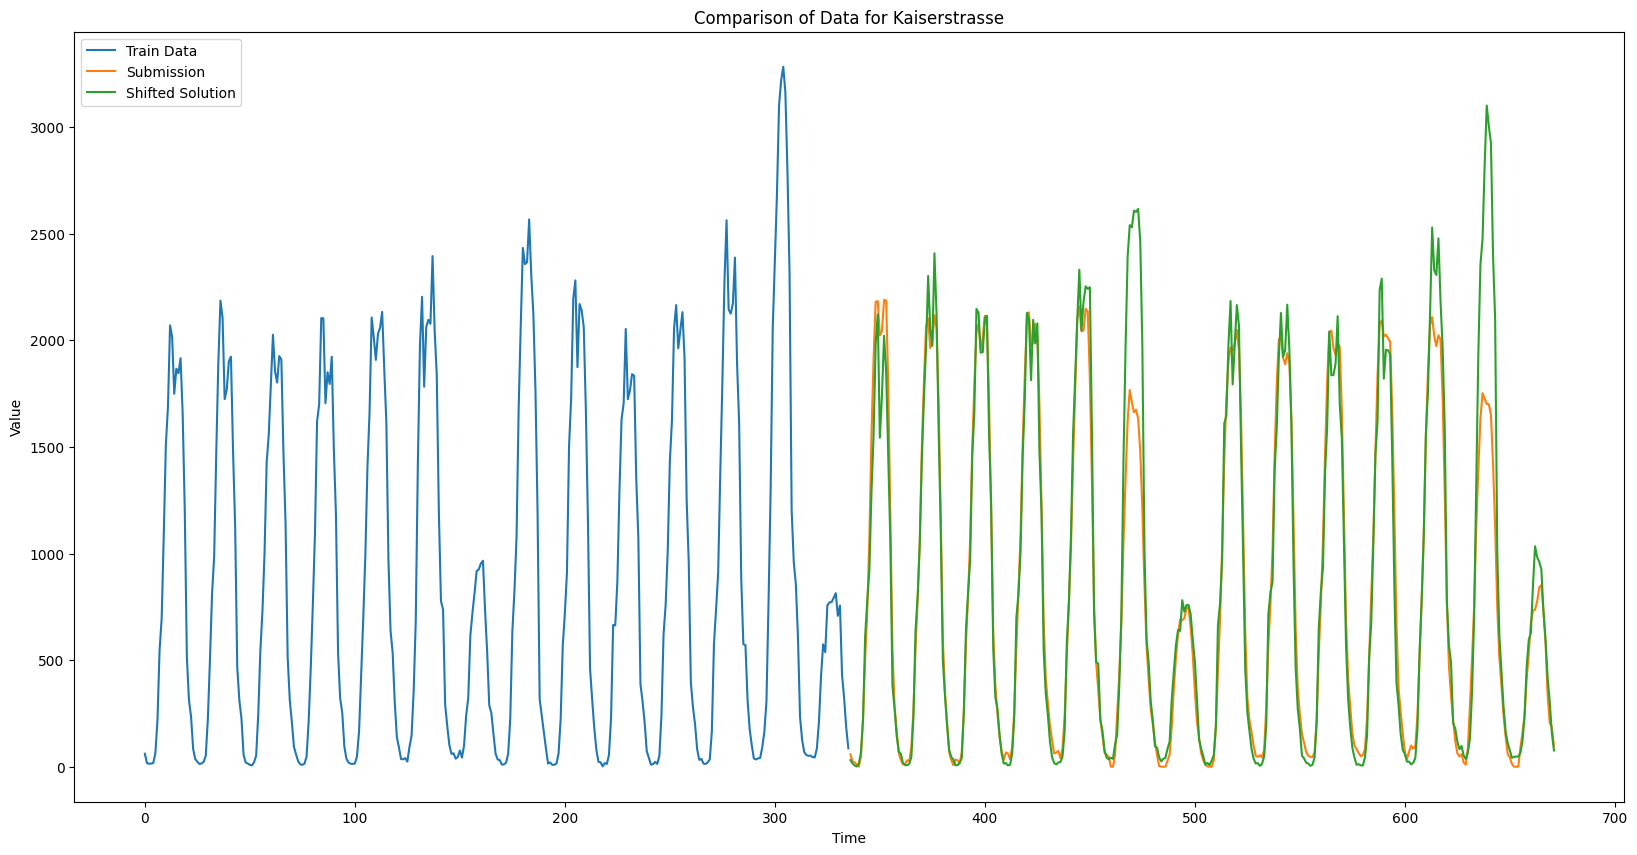

In [206]:
streetname = "Kaiserstrasse"
variable_of_interest = "n_pedestrians"
solution["temp_streetname"] = 0

for streetname in streetnames:
    solution["temp_streetname"] = solution.apply(
        lambda row: streetname if streetname in row['id'] else row['temp_streetname'], axis=1
    )

# Create the figure and set the size
plt.figure(figsize=(20,10))

# Plot the first dataset
plt.plot(train[train["streetname"] == streetname][variable_of_interest].values[-n_last_obs:], label='Train Data')

# # Plot the second dataset
n_pedestrians = submission[submission["temp_streetname"] == streetname][variable_of_interest].values

shifted_submission = np.pad(
    n_pedestrians,
    (n_last_obs, 0), 'constant', constant_values=(np.nan,)
)

plt.plot(shifted_submission, label='Submission')

# Shift the third dataset by n_last_obs to the right by padding with NaN values
n_pedestrians = solution[solution["temp_streetname"] == streetname][variable_of_interest].astype(float).values

shifted_solution = np.pad(
    n_pedestrians,
    (n_last_obs, 0), 'constant', constant_values=(np.nan,)
)

# Plot the shifted solution
plt.plot(shifted_solution, label='Shifted Solution')

# Add labels, title, and legend
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Comparison of Data for {streetname}")
plt.legend()

# Show the plot
plt.show()

In [124]:
submission

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,temp_streetname
0,Schoenbornstrasse_2024-09-16_0,17.890808,11.483307,12.504089,Schoenbornstrasse
1,Schoenbornstrasse_2024-09-16_1,5.956329,5.956329,0.000000,Schoenbornstrasse
2,Schoenbornstrasse_2024-09-16_2,26.161835,26.161835,0.000000,Schoenbornstrasse
3,Schoenbornstrasse_2024-09-16_3,11.684601,11.684601,0.000000,Schoenbornstrasse
4,Schoenbornstrasse_2024-09-16_4,0.000000,0.000000,0.000000,Schoenbornstrasse
...,...,...,...,...,...
1003,Kaiserstrasse_2024-09-29_19,311.367600,268.194672,311.770874,Kaiserstrasse
1004,Kaiserstrasse_2024-09-29_20,220.940791,149.392212,183.868835,Kaiserstrasse
1005,Kaiserstrasse_2024-09-29_21,156.674205,88.472504,115.699768,Kaiserstrasse
1006,Kaiserstrasse_2024-09-29_22,107.229264,88.017487,97.414185,Kaiserstrasse


In [94]:
submission = submission_timesFM.copy()
submission.to_csv("submission.csv", index=False)
submission

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away
0,Schoenbornstrasse_2024-09-16_0,17.890808,11.483307,12.504089
1,Schoenbornstrasse_2024-09-16_1,5.956329,5.956329,0.000000
2,Schoenbornstrasse_2024-09-16_2,26.161835,26.161835,0.000000
3,Schoenbornstrasse_2024-09-16_3,11.684601,11.684601,0.000000
4,Schoenbornstrasse_2024-09-16_4,0.000000,0.000000,0.000000
...,...,...,...,...
1003,Kaiserstrasse_2024-09-29_19,552.124084,268.194672,311.367600
1004,Kaiserstrasse_2024-09-29_20,314.337708,149.392212,220.940791
1005,Kaiserstrasse_2024-09-29_21,190.600342,88.472504,156.674205
1006,Kaiserstrasse_2024-09-29_22,177.636902,88.017487,107.229264


In [337]:
# save submission
submission = submission.drop(columns=["temp_streetname"])
submission.to_csv("submission.csv", index=False)

In [338]:
# read submission
submission = pd.read_csv("submission.csv")
submission.head()

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away
0,Schoenbornstrasse_2024-09-16_0,24.894345,24.894345,0.0
1,Schoenbornstrasse_2024-09-16_1,55.821529,55.821529,0.0
2,Schoenbornstrasse_2024-09-16_2,76.516439,76.516439,0.0
3,Schoenbornstrasse_2024-09-16_3,20.335949,100.595749,0.0
4,Schoenbornstrasse_2024-09-16_4,88.112265,136.375500,0.0


In [339]:
solution

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away,Usage,temp_streetname
0,Schoenbornstrasse_2024-09-16_0,19,6,13,Public,Schoenbornstrasse
1,Schoenbornstrasse_2024-09-16_1,15,8,7,Public,Schoenbornstrasse
2,Schoenbornstrasse_2024-09-16_2,7,5,2,Public,Schoenbornstrasse
3,Schoenbornstrasse_2024-09-16_3,2,0,2,Public,Schoenbornstrasse
4,Schoenbornstrasse_2024-09-16_4,6,1,5,Public,Schoenbornstrasse
...,...,...,...,...,...,...
1003,Kaiserstrasse_2024-09-29_19,595,282,313,Private,Kaiserstrasse
1004,Kaiserstrasse_2024-09-29_20,416,212,204,Private,Kaiserstrasse
1005,Kaiserstrasse_2024-09-29_21,304,157,147,Private,Kaiserstrasse
1006,Kaiserstrasse_2024-09-29_22,158,82,76,Private,Kaiserstrasse


In [340]:
submission

,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away
0,Schoenbornstrasse_2024-09-16_0,24.894345,24.894345,0.000000
1,Schoenbornstrasse_2024-09-16_1,55.821529,55.821529,0.000000
2,Schoenbornstrasse_2024-09-16_2,76.516439,76.516439,0.000000
3,Schoenbornstrasse_2024-09-16_3,20.335949,100.595749,0.000000
4,Schoenbornstrasse_2024-09-16_4,88.112265,136.375500,0.000000
...,...,...,...,...
1003,Kaiserstrasse_2024-09-29_19,1155.532874,528.855664,618.108827
1004,Kaiserstrasse_2024-09-29_20,560.100285,242.039716,307.407369
1005,Kaiserstrasse_2024-09-29_21,420.945990,184.164045,229.940650
1006,Kaiserstrasse_2024-09-29_22,304.202392,117.465829,183.969357
